**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer to all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions as a single .zip file to the Site Pédagogique before the 5th of February 2020 (23h59). Name it as 'TP1-IMA205-YOUR-SURNAME.zip'.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

Otherwise, you can also load them from your local machine using the following code

In [45]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

Let's load the Python packages containing the functions needed for the practical session.

In [0]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

We also load a user-defined function useful for plotting the confusion matrix

In [0]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark positions should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [48]:
# Parameters
dim=2 # dimension   
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

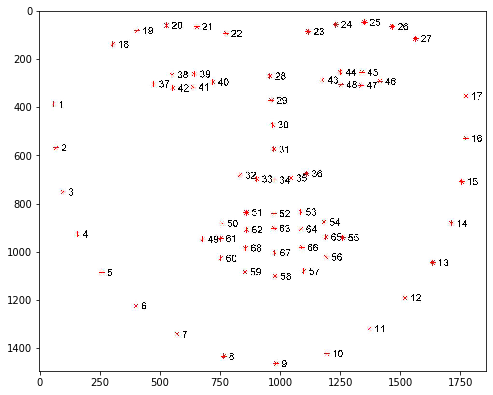

In [49]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

[ 27. 107.  27. 133.  30. 158.  34. 184.  39. 209.  49. 233.  67. 253.
  89. 270. 118. 276. 148. 273. 176. 261. 201. 243. 217. 219. 226. 192.
 232. 165. 239. 137. 243. 108.  37.  87.  51.  77.  68.  75.  87.  77.
 105.  83. 142.  82. 161.  75. 181.  72. 201.  74. 217.  85. 123.  98.
 122. 114. 121. 129. 120. 146. 102. 166. 111. 169. 120. 171. 131. 170.
 141. 167.  57. 106.  69.  97.  84.  96.  98. 107.  83. 110.  68. 110.
 153. 106. 168.  96. 183.  96. 196. 105. 184. 110. 168. 109.  78. 204.
  94. 196. 110. 190. 120. 193. 130. 191. 146. 197. 166. 207. 145. 219.
 129. 223. 118. 223. 107. 221.  93. 216.  85. 205. 109. 203. 120. 204.
 130. 204. 158. 207. 129. 205. 119. 205. 109. 204.]
[ 27.  27.  30.  34.  39.  49.  67.  89. 118. 148. 176. 201. 217. 226.
 232. 239. 243.  37.  51.  68.  87. 105. 142. 161. 181. 201. 217. 123.
 122. 121. 120. 102. 111. 120. 131. 141.  57.  69.  84.  98.  83.  68.
 153. 168. 183. 196. 184. 168.  78.  94. 110. 120. 130. 146. 166. 145.
 129. 118. 107.  93.  85.

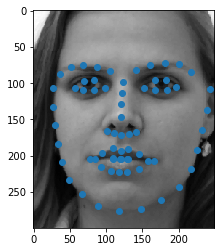

[0]
[ 27. 113.  27. 139.  28. 164.  29. 190.  36. 215.  50. 239.  71. 260.
  94. 277. 121. 284. 150. 279. 176. 264. 198. 245. 215. 221. 223. 195.
 228. 167. 233. 141. 236. 113.  39.  90.  53.  79.  71.  76.  90.  78.
 107.  84. 144.  84. 162.  77. 182.  75. 201.  79. 216.  90. 125. 100.
 125. 115. 124. 130. 124. 146. 102. 162. 113. 165. 124. 168. 136. 165.
 147. 163.  60. 106.  72.  98.  85.  99.  99. 107.  85. 108.  72. 108.
 153. 107. 168.  98. 181.  99. 194. 106. 182. 108. 168. 108.  70. 195.
  89. 186. 110. 181. 124. 184. 138. 181. 160. 186. 182. 195. 161. 222.
 139. 233. 124. 235. 108. 233.  88. 221.  76. 197. 110. 190. 124. 191.
 138. 191. 175. 197. 139. 218. 124. 219. 109. 218.]
[ 27.  27.  28.  29.  36.  50.  71.  94. 121. 150. 176. 198. 215. 223.
 228. 233. 236.  39.  53.  71.  90. 107. 144. 162. 182. 201. 216. 125.
 125. 124. 124. 102. 113. 124. 136. 147.  60.  72.  85.  99.  85.  72.
 153. 168. 181. 194. 182. 168.  70.  89. 110. 124. 138. 160. 182. 161.
 139. 124. 108.  88. 

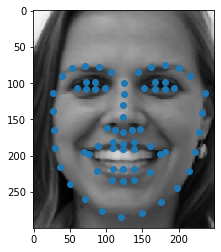

[1]
[ 12. 120.  13. 148.  16. 176.  20. 203.  29. 229.  45. 251.  70. 267.
  98. 277. 129. 281. 160. 277. 186. 267. 207. 251. 219. 228. 225. 202.
 229. 175. 232. 147. 232. 119.  34.  90.  47.  77.  65.  69.  86.  68.
 106.  73. 147.  72. 166.  66. 187.  67. 204.  74. 217.  87. 127.  96.
 127. 110. 128. 123. 128. 138. 109. 165. 118. 166. 128. 167. 138. 166.
 146. 164.  57. 109.  69. 100.  84.  98.  98. 107.  85. 111.  69. 113.
 154. 107. 168.  98. 183.  98. 194. 108. 183. 112. 168. 111.  85. 208.
 104. 198. 119. 191. 129. 193. 140. 191. 155. 196. 172. 206. 156. 214.
 142. 216. 131. 217. 120. 216. 104. 214.  92. 207. 119. 203. 130. 204.
 140. 203. 166. 206. 140. 203. 130. 204. 120. 203.]
[ 12.  13.  16.  20.  29.  45.  70.  98. 129. 160. 186. 207. 219. 225.
 229. 232. 232.  34.  47.  65.  86. 106. 147. 166. 187. 204. 217. 127.
 127. 128. 128. 109. 118. 128. 138. 146.  57.  69.  84.  98.  85.  69.
 154. 168. 183. 194. 183. 168.  85. 104. 119. 129. 140. 155. 172. 156.
 142. 131. 120. 104. 

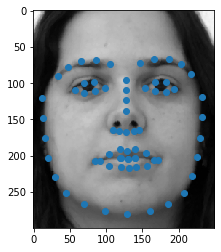

[0]
[ 15. 123.  15. 150.  19. 177.  23. 204.  32. 231.  49. 254.  74. 270.
 100. 283. 128. 287. 157. 281. 183. 268. 207. 252. 223. 230. 231. 203.
 233. 175. 235. 148. 235. 122.  32.  96.  44.  81.  62.  72.  83.  70.
 103.  74. 145.  73. 165.  68. 186.  68. 204.  77. 217.  91. 125.  96.
 125. 109. 125. 122. 125. 136. 103. 158. 114. 160. 125. 163. 137. 160.
 147. 157.  58. 109.  69. 102.  82. 101.  96. 106.  83. 108.  70. 109.
 154. 106. 169. 100. 181. 101. 193. 107. 181. 108. 168. 107.  72. 197.
  90. 185. 111. 179. 126. 181. 140. 178. 161. 183. 182. 194. 163. 216.
 142. 225. 127. 227. 112. 226.  90. 217.  78. 197. 112. 187. 126. 188.
 140. 186. 176. 195. 141. 215. 127. 216. 112. 215.]
[ 15.  15.  19.  23.  32.  49.  74. 100. 128. 157. 183. 207. 223. 231.
 233. 235. 235.  32.  44.  62.  83. 103. 145. 165. 186. 204. 217. 125.
 125. 125. 125. 103. 114. 125. 137. 147.  58.  69.  82.  96.  83.  70.
 154. 169. 181. 193. 181. 168.  72.  90. 111. 126. 140. 161. 182. 163.
 142. 127. 112.  90. 

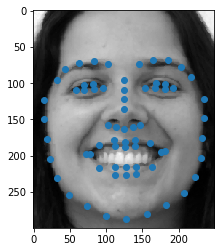

[1]
[ 20. 111.  22. 138.  27. 164.  32. 189.  42. 213.  57. 235.  79. 252.
 104. 265. 131. 269. 158. 265. 181. 250. 200. 232. 212. 209. 220. 185.
 225. 160. 227. 135. 227. 109.  37.  92.  51.  80.  70.  75.  89.  76.
 107.  83. 143.  83. 161.  77. 180.  76. 198.  81. 211.  92. 128. 101.
 129. 121. 130. 140. 131. 161. 111. 174. 121. 177. 131. 180. 140. 177.
 149. 173.  57. 106.  69.  99.  83.  99.  97. 109.  83. 111.  69. 111.
 154. 109. 167.  99. 181.  98. 193. 106. 182. 111. 168. 111.  92. 207.
 108. 201. 123. 197. 132. 199. 141. 197. 155. 200. 170. 207. 155. 215.
 143. 219. 133. 220. 123. 219. 109. 215.  98. 207. 122. 207. 132. 208.
 141. 207. 165. 207. 142. 207. 133. 208. 123. 207.]
[ 20.  22.  27.  32.  42.  57.  79. 104. 131. 158. 181. 200. 212. 220.
 225. 227. 227.  37.  51.  70.  89. 107. 143. 161. 180. 198. 211. 128.
 129. 130. 131. 111. 121. 131. 140. 149.  57.  69.  83.  97.  83.  69.
 154. 167. 181. 193. 182. 168.  92. 108. 123. 132. 141. 155. 170. 155.
 143. 133. 123. 109. 

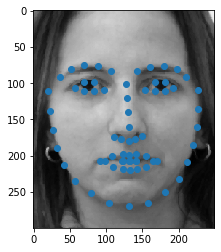

[0]
[ 21. 114.  23. 141.  26. 166.  31. 192.  42. 216.  59. 238.  82. 256.
 106. 272. 132. 277. 158. 271. 180. 254. 200. 234. 214. 211. 223. 188.
 226. 163. 227. 138. 226. 112.  39.  96.  53.  84.  71.  78.  91.  78.
 108.  85. 146.  87. 163.  80. 182.  79. 200.  85. 212.  98. 129. 104.
 130. 122. 131. 141. 132. 160. 108. 168. 119. 172. 131. 177. 142. 173.
 152. 169.  60. 108.  71. 101.  84. 101.  98. 110.  84. 111.  71. 111.
 155. 111. 168. 101. 181. 101. 193. 108. 182. 111. 169. 111.  77. 195.
  95. 187. 116. 186. 130. 189. 143. 187. 162. 189. 179. 196. 163. 222.
 144. 233. 130. 234. 114. 232.  94. 219.  82. 196. 116. 193. 130. 195.
 143. 194. 174. 196. 143. 221. 130. 222. 115. 220.]
[ 21.  23.  26.  31.  42.  59.  82. 106. 132. 158. 180. 200. 214. 223.
 226. 227. 226.  39.  53.  71.  91. 108. 146. 163. 182. 200. 212. 129.
 130. 131. 132. 108. 119. 131. 142. 152.  60.  71.  84.  98.  84.  71.
 155. 168. 181. 193. 182. 169.  77.  95. 116. 130. 143. 162. 179. 163.
 144. 130. 114.  94. 

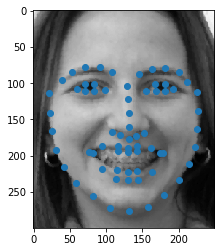

[1]


In [50]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    print(landmark)
    x=landmark[::2]
    print(x)
    y=landmark[1::2]
    lab=Y[i]
    plt.plot(x,y,'o')
    plt.show()
    print(lab)



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---



Grâce aux landmarks de la bouche, nous allons pouvoir distinguer les visages heureux des visages neutres. 
Avant de séparer nos données en training set, validation set et test set, il est mieux de les mélanger, pour éviter d'avoir toujours les deux visages correspondant l'un après l'autre. Ici, nous n'avons que des visages féminins au début.

On va donc mélanger toutes nos datas avant l'apprentissage.

Here is the new order
[195 143 352  17 370 296  18 272 285  33 128  49 323   0 117 304  56  50
  96  94  55 337 268 364 167  23 216 263 254  54 286 395 360  64  48 259
 220 206 242 123 345 224 231   3 196 162 209 211 121 179 284 346 279 399
 306 246 150 238  21  29 252 189 118 269 165  41  62 251 362 380 377 372
  35 232 398 185 159 332 250 135  95 256 227 187 280  61 293 248   7 312
  76  15  65 288 127  38 353  93 381 114 239 394 160  20 376 158 137 369
   8 348 258 322  97 198 226 106 382 207  11 324 230 299 344  34 374 244
 391 178 291 265  75 341 149  66   1  12 300 172 271 273 180 184 181  14
 176 297 104 327  87 109 152  89 392 384  92 205   6 240 171  78 154 366
 266 229 116 343 320 389 199  98 190 375 336 129 101 388 140  53 186 124
  71 355 235 110 302 363 182  58 321 331 111 326 131 311 188 315   4 215
 173 108 243 347 163 309 214 365 146 257 330  25 213 278 358  68 201 132
   5 153 193  40 119  74  22  19  59 317 349 170 115 307  44 237 228  31
 338 234  43  85 105 134 356 

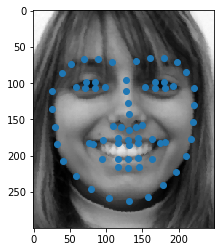

[1]


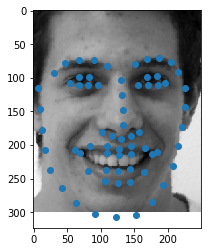

[1]


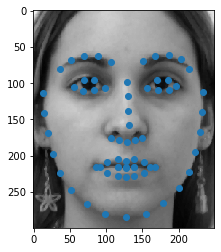

[0]


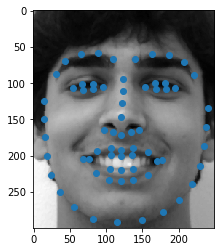

[1]


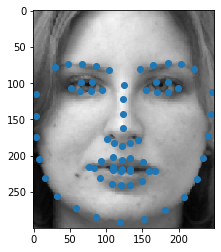

[0]


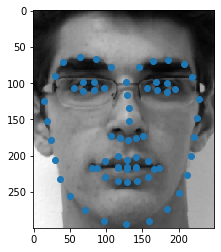

[0]


In [51]:
# Shuffle data randomly. Hint: Use np.random.shuffle


ordre=np.arange(0,N)
np.random.shuffle(ordre)

print("Here is the new order")
print(ordre)

# Use as new variables
XpGPA=XGPA[ordre[:]]
Xp=X[ordre[:]]
Yp=Y[ordre[:]]
Imagesp=Images[ordre[:]]
Xmean = np.mean(XpGPA,axis=0) # Compute average
Namesp=Names[ordre[:]]

# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xp[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    lab=Yp[i]
    plt.plot(x,y,'o')
    plt.show()
    print(lab)



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. 

**Question**: Check them and compare them with the landmarks before alignement. Describe the differences.

In the following, we will use the landmarks after GPA (*XpGPA*)




---



**Response**: juste après le code correspondant 

Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

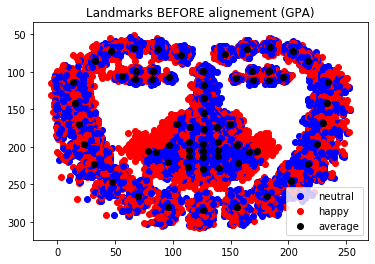

In [52]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

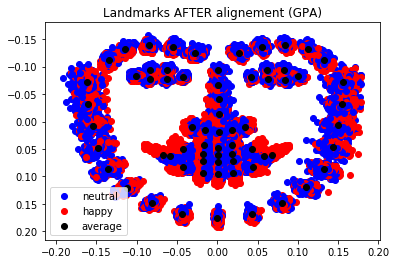

In [53]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')

---

**Response**: Avant l'alignement GPA on voit que les landmarks sont très éparpillés. Une fois qu'ils sont alignés, on distingue bien le sourire en rouge de la bouche neutre en bleue. 

---



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the (aligned) landmarks of every subject and the landmarks of the average configuration. Please remember to use XpGPA.



---



In [54]:
# Compute distances from the average configuration (features)


def dist_m(i):
  landmark=XpGPA[i]
  x=landmark[::2]
  y=landmark[1::2]
  xm,ym=Xmean[::2],Xmean[1::2]
  return np.sqrt(((x-xm)**2+(y-ym)**2))

dist_average=np.array([dist_m(i) for i in range(len(XpGPA))])

print(dist_average)

[[0.00258905 0.00205613 0.00297324 ... 0.01131283 0.01093802 0.01140833]
 [0.00443115 0.00288625 0.00285427 ... 0.01653513 0.01697774 0.01717356]
 [0.00100198 0.00201679 0.00282666 ... 0.00367861 0.00042429 0.00295172]
 ...
 [0.02160176 0.01940511 0.01722344 ... 0.01074349 0.00976458 0.00965798]
 [0.00710895 0.00395009 0.00104907 ... 0.00591282 0.00429471 0.00454745]
 [0.00781756 0.00666185 0.00686204 ... 0.00652567 0.00861915 0.01089884]]


---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

---

---

**Response:** 
En Machine Learning, on normalise souvent nos données afin que tous les features aient le même poids. Si un feature possède un poids plus grand que les autres il dominera la fonction objectif et influencera beaucoup plus la descente de gradient. 

Mais ici, tous les features (distance des landmarks à la moyenne) ont été calculés de la même façon et ont donc le même poids : rien ne sert de normaliser. 

---

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(dist_average)
dist_average_scale=scaler.transform(dist_average)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
scaler.fit(dist_average)
dist_min_max_scale=scaler.transform(dist_average)

Let's divide the data-set into Training and Test sets using original, scaled and normalized data.

In [0]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(dist_average_scale, np.ravel(Yp), test_size=0.33, random_state=42)

X_train3, X_test3, y_train3, y_test3 = train_test_split(dist_min_max_scale, np.ravel(Yp), test_size=0.33, random_state=42)



---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performances between original, scaled and normalized data. Comment the results.



---



**Response**: juste après le code correspondant

Fitting LDA to training set
done in 0.016s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

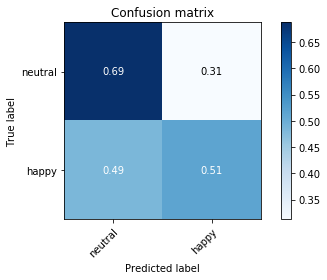

In [57]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.009s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

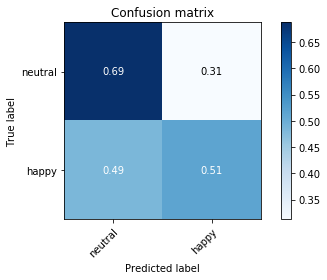

In [58]:
# Fitting LDA to scale data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train2, y_train2)
y_pred2 = lda.predict(X_test2)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test2, y_pred2))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test2, y_pred2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.014s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

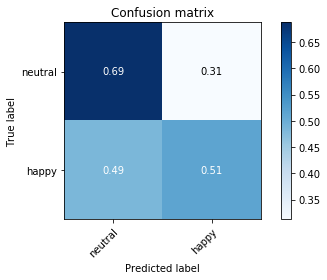

In [59]:
# Fitting LDA to normalize data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train3, y_train3)
y_pred3 = lda.predict(X_test3)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test3, y_pred3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test3, y_pred3)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

--- 

**Response**: Les résultats sont très mauvais donc les features ne sont pas correctement choisis. Comme ont l'avait prévu, il n'y a aucune conséquence si l'on normalise ou non les données. 

---



---



We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

**Question**: compare the performances between original, scaled and normalized data



---






--- 

**Response**:

LDA n'est pas sensible à la normalisation des données. 
QDA et Bayes devraient l'être, mais les matrices de covariances des features sont tellement proches que la normalisation n'a pas de conséquence sur le résultat.
Pour ce qui est de la logistic regression, la frontière linéaire est déplacée si l'on normalise ou non les données. On obtient des résultats légérement meilleurs si l'on utilise scale data. 

Comme le minimum de dist_average est très faible, Knn n'est pas très sensible à la normalisation des données.

---

In [60]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.057s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.041s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.027s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.018s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.074s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


In [61]:
"""# Cross-validation for Model Assessment with scale data

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))"""

'# Cross-validation for Model Assessment with scale data\n\n# Fitting LDA\nprint("Fitting LDA")\nt0 = time()\nlda = LinearDiscriminantAnalysis()\nlda_score = cross_val_score(lda,X=dist_average_scale, y=np.ravel(Yp),cv=5)\nprint("done in %0.3fs" % (time() - t0))\nprint(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))\n\n# Fitting QDA\nprint("Fitting QDA")\nt0 = time()\nqda = QuadraticDiscriminantAnalysis()\nqda_score = cross_val_score(qda,X=dist_average_scale, y=np.ravel(Yp),cv=5)\nprint("done in %0.3fs" % (time() - t0))\nprint(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))\n\n# Fitting Logistic-regression\nprint("Fitting Logistic Regression")\nt0 = time()\nlogit = LogisticRegression(solver=\'lbfgs\')\nlogit_score = cross_val_score(logit,X=dist_average_scale, y=np.ravel(Yp),cv=5)\nprint("done in %0.3fs" % (time() - t0))\nprint(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

In [65]:
# Cross-validation for Model Assessment (data normalized)

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_min_max_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_min_max_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_min_max_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_min_max_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_min_max_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() )) 

Fitting LDA
done in 0.071s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.045s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.117s
 Average and std CV score : 0.5675000000000001 +- 0.03674234614174766
Fitting Naive-Bayes
done in 0.013s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.072s
 Average and std CV score : 0.5775 +- 0.03482097069296032




---



In the previous example we have fixed the hyper-parameter K to 3. We coudl use CV to find the best value.



---



The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')

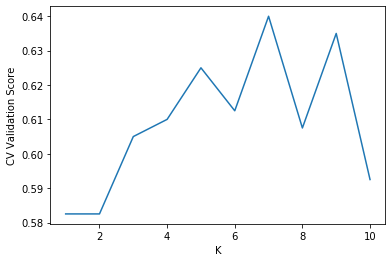

In [66]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091


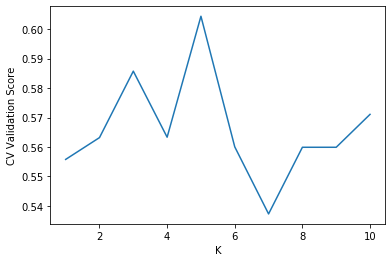

In [67]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previosu experiments. What about the best K and validation error ? Are the results the same ? Why in your opinion ?



---



---

**Response**: Dans la première méthode, on utilise à la fois les données du training set et celles du test sets. On obtient un meilleur résultat sur le training set. 

Cependant, il est déconseillé de choisir le meilleur estimateur en utilisant toutes les données. Sinon, rien ne sert d'utiliser un test set...

Avec la deuxième méthode, qui n'utilise que le training set pour estimer le meilleur K, on obtient K=5 au lieu de K=7, et le résultat pour le test set est bon. 
On aura un meilleur pouvoir de généralisation.

---



---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [0]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))
dist_combination2=np.zeros((N,int((M*(M-1)/2))))

def dist_comb(landmark):
  res=[]
  for i in range(0,2*M,2):
    for j in range(0,i,2):
      res.append(np.sqrt((landmark[i]-landmark[j])**2+(landmark[i+1]-landmark[j+1])**2))
  return res

dist_combination=np.array([dist_comb(XpGPA[i]) for i in range(len(XpGPA))])



**Question**: As before, should we scale/normalize the data ?

**Response**: Oui, sinon certaines distances entre landmarks seront plus importantes (les plus grandes) 

In [0]:
row_sums = dist_combination.sum(axis=1) 
dist_combination_scale = np.zeros((400,2278))
for i, (row, row_sum) in enumerate(zip(dist_combination, row_sums)):
    dist_combination_scale[i,:] = row / row_sum

**Question**: Use the classification algorithms seen before to test the discriminative power of the new features. 

In [70]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 1.624s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting QDA


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.849s
 Average and std CV score : 0.6475000000000001 +- 0.05830951894845299
Fitting Logistic Regression
done in 0.071s
 Average and std CV score : 0.9375 +- 0.02236067977499788
Fitting Naive-Bayes
done in 0.092s
 Average and std CV score : 0.95 +- 0.028504385627478455
Fitting K-nearest neighbour
done in 0.890s
 Average and std CV score : 0.9425000000000001 +- 0.024494897427831803




---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. We could use a very well-known technique called PCA (Principal Component Analysis). We will see it in few lectures...



---



In [71]:
# We could use PCA to map the data to a new coordiante system where the new variables would be orthogonal among each other. (so no more collinear...)
pca = decomposition.PCA(n_components=0.9) # use number of components take explain 90% of variability
pca.fit(dist_combination)
dist_combination_pca = pca.transform(dist_combination_scale)  

print('Number of subjects N is: ', dist_combination_pca.shape[0], ' ; number of features is: ',  dist_combination_pca.shape[1] )

Number of subjects N is:  400  ; number of features is:  8


**Question**: Test the predictive power of the new features

In [72]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.016s
 Average and std CV score : 0.9550000000000001 +- 0.024494897427831803
Fitting QDA
done in 0.009s
 Average and std CV score : 0.97 +- 0.032210246816812824
Fitting Logistic Regression
done in 0.017s
 Average and std CV score : 0.9349999999999999 +- 0.018371173070873832
Fitting Naive-Bayes
done in 0.008s
 Average and std CV score : 0.9549999999999998 +- 0.02318404623873926
Fitting K-nearest neighbour
done in 0.024s
 Average and std CV score : 0.945 +- 0.023184046238739254




---


A second solution, would be to manually select few landmarks



---



In [73]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


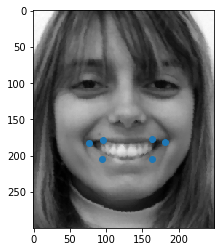

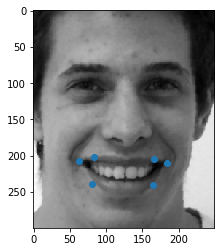

In [74]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

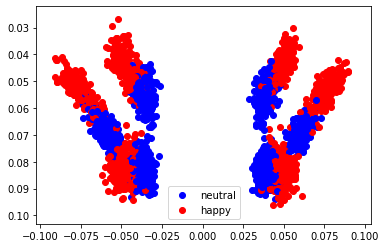

In [75]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [76]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

"""for i in range(len(error)):
  plt.imshow(Images[error[i]],cmap='gray')
  plt.show()"""

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


"for i in range(len(error)):\n  plt.imshow(Images[error[i]],cmap='gray')\n  plt.show()"

---

Let's plot some images where the best model was wrong. 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks

---

--- 

**Response**:
Toutes les erreurs concernent des personnes que sont consiédérées "neutral" alors qu'elles sont "happy". A chaque fois, les sourires sont très plats ! Les 3 points que l'on a sélectionné dans les deux coins de la bouche forment donc un triangle quasi-isocèle comme dans le cas des bouches neutres, ce qui est différent de la position des landmarks quand la personne possède un petit sourire en coin !

Conclusion : il faut prendre d'autres landmarks pour éviter ces erreurs, même si ici, c'est compliqué, car les personnes n'ont pas un sourire très marqué !

---

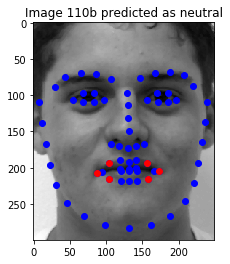

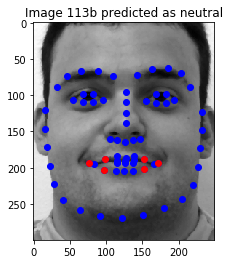

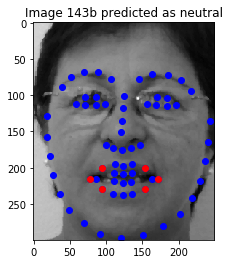

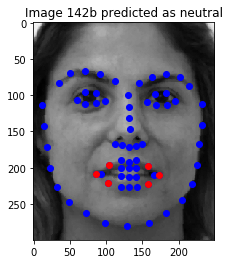

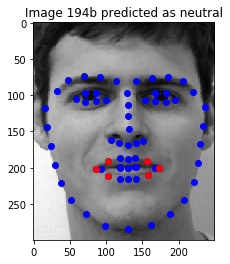

In [77]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

##Essai avec des landmarks en plus 

In [78]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56,68,64]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  16


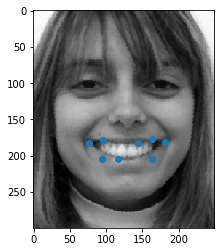

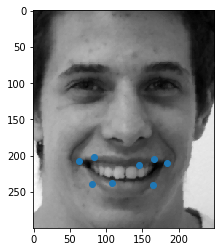

In [79]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

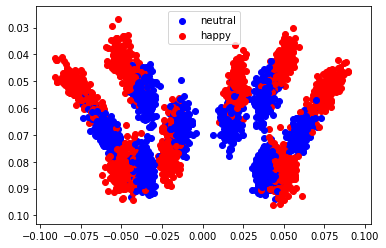

In [80]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [81]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

"""for i in range(len(error)):
  plt.imshow(Images[error[i]],cmap='gray')
  plt.show()"""

Fitting LDA
 Average and std train score : 0.9675 +- 0.0025000000000000356
 Average and std test score : 0.9500000000000002 +- 0.013693063937629145


"for i in range(len(error)):\n  plt.imshow(Images[error[i]],cmap='gray')\n  plt.show()"

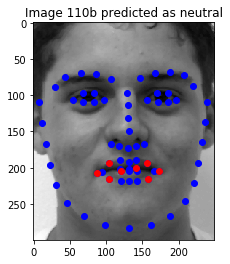

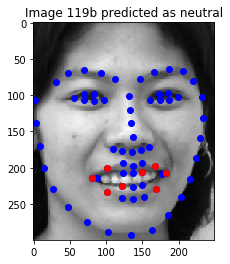

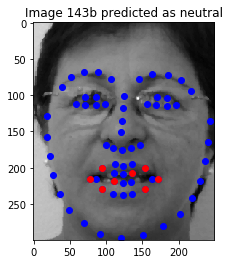

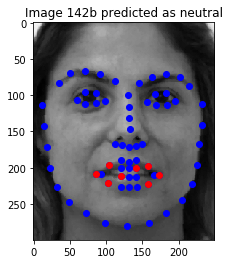

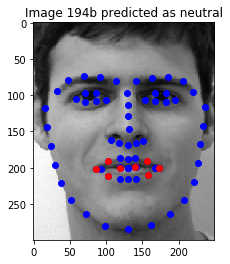

In [82]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

On a très très légérement amélioré nos deux scores en ajoutant ces deux landmarks. Il faut peut être repenser la méthode en ajoutant un feature sur la couleur moyenne autour de la bouche par exemple.




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [83]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 1.497s
Average and std Nested Cv train score : 0.9662499999999999 +- 0.005376453291901638
Average and std Nested Cv test score : 0.96 +- 0.022912878474779224


---

**Question**: Are Training and Test scores similar ? What does it mean ?

---

--- 

**Response :** Avec le cross-validation, on obtient un score d'environ 0.97 sur le training set et un score de 0.96 sur le test set. 
Ces deux scores sont quasi égaux : notre méthode a un très grand pouvoir de généralisation !! 

---

**Question**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power

In [112]:
# On definit moyenne_bouche qui donne la moyenne des pixels de la bouche
# si cette moyenne tend vers le blanc, on peut imaginer qu'il y a un sourire  
from numpy import *

def moyenne_bouche(i):
  s=0
  landmark=X[i,:]
  haut=landmark[2*51-2]    #51 : landmark du haut de la bouche 
  bas=landmark[2*58-2]
  gauche=landmark[2*49-1]
  droite=landmark[2*55-1]
  for k in range(int(haut),int(bas)):
    for j in range(int(gauche),int(droite)):
      s+=Images[i][k][j]
  return s/((bas-haut)*(droite-gauche))



colors=[moyenne_bouche(i) for i in ordre]


dist_color=[]
for i in range(len(Xp)):
  r=dist_comb(XpGPA[i])
  r.append(colors[i])
  dist_color.append(r)

scaler = StandardScaler()
scaler.fit(dist_color)
dist_color_scale=scaler.transform(dist_color)

where_are_NaNs = isnan(dist_color_scale)
dist_color_scale[where_are_NaNs] = 0




# We could use PCA to map the data to a new coordiante system where the new variables would be orthogonal among each other. (so no more collinear...)
pca = decomposition.PCA(n_components=0.8) # use number of components take explain 90% of variability
pca.fit(dist_color_scale)
dist_color_pca = pca.transform(dist_color_scale)  

print('Number of subjects N is: ', dist_color_pca.shape[0], ' ; number of features is: ',  dist_combination_pca.shape[1] )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Number of subjects N is:  400  ; number of features is:  8


Fitting LDA to training set
done in 0.232s
              precision    recall  f1-score   support

           0       0.88      0.95      0.92        64
           1       0.95      0.88      0.92        68

    accuracy                           0.92       132
   macro avg       0.92      0.92      0.92       132
weighted avg       0.92      0.92      0.92       132

Normalized confusion matrix
[[0.953125   0.046875  ]
 [0.11764706 0.88235294]]


<Figure size 432x288 with 0 Axes>

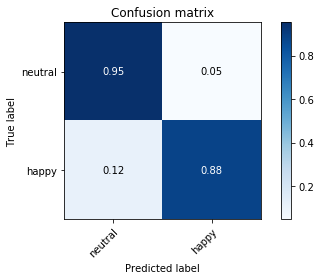

In [113]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

MY PIPELINE 

J'ai voulu rajouter une information sur la couleur de l'image.
J'ai hésité entre prendre les couleurs moyennes autour de chaque landmark mais il y aurait eu des informations en double (colinéarité dans les Xi). 
J'ai donc préféré simplement prendre la moyenne dans la zone de la bouche. Je me suis dit que quand il y avait un sourire, on voyait souvent les dents et la couleur tendrait ainsi vers le blanc. 

Les autres Xi sont les mêmes que pour dist_combination. 

Finalement, ajouter cette couleur n'augmente que très peu la précision : on passe d'un score de 0.91 à un score de 0.92.